<a href="https://colab.research.google.com/github/cabamarcos/P1-RRNN/blob/main/P1_RRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

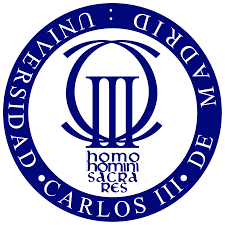

# PRÁCTICA 1: REDES DE NEURONAS
Autores: Pablo Hidalgo Delgado y Marcos Caballero Cortés   

NIAs: 100451225 y 100451247


#PREGUNTAS PROFE


*   





## 1. Introducción
El propósito de esta práctica es abordar un problema real de regresión utilizando dos modelos de redes de neuronas supervisados:

*   El modelo lineal Adaline.
*   El modelo no-lineal Perceptrón Multicapa.

Se nos dispone de un conjunto de datos relacionados con .... . Debemos predecir el .... ,




Importamos todas las librerías que se van a utilizar a lo largo de la práctica

In [85]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

## 2. Leer los conjuntos de datos


En primer lugar, leemos los conjuntos de datos y los guardamos en un mismo dataframe

In [86]:
archivos_csv = ['gt_2011.csv', 'gt_2012.csv', 'gt_2013.csv', 'gt_2014.csv', 'gt_2015.csv']

datos = pd.DataFrame()

# Concatenamos todos los archivos en un mismo dataframe
for archivo in archivos_csv:
    # Leemos el archivo
    df_temporal = pd.read_csv(archivo)
    # Concatenamos el archivo en el dataframe final
    datos = pd.concat([datos, df_temporal], ignore_index=True)

## 3. Análisis Exploratorio de Datos (EDA)
Antes de empezar con la división en datos de entrenamiento y test, vamos a realizar un pequeño análisis exploratorio de datos (EDA). De esta manera, podremos investigar y resumir las características más importantes de nuestro dataset. Esto nos servirá para comprender mejor los datos y optimizar la obtención de nuestro modelo.

### 3.1 Información básica

In [87]:
datos.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36733 entries, 0 to 36732
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      36733 non-null  float64
 1   AP      36733 non-null  float64
 2   AH      36733 non-null  float64
 3   AFDP    36733 non-null  float64
 4   GTEP    36733 non-null  float64
 5   TIT     36733 non-null  float64
 6   TAT     36733 non-null  float64
 7   TEY     36733 non-null  float64
 8   CDP     36733 non-null  float64
 9   CO      36733 non-null  float64
 10  NOX     36733 non-null  float64
dtypes: float64(11)
memory usage: 3.1 MB


El conjunto de datos se compone de 36733 instancias y 11 atributos de tipo float64.

También podemos comprobar que no existen columnas que contengan valores nulos.

### 3.2 Eliminación de atributos con valores constantes

A continuación, vamos a analizar si existen columnas constantes en nuestro conjunto de datos. En ese caso, podremos eliminarlas de nuestro dataset ya que no aportan ninguna información a la variable de respuesta.

In [88]:
# Eliminamos las columnas con solo un valor único
columnas_constantes = []
for col in datos.columns:
    if datos[col].nunique() == 1:
        print(col)
        columnas_constantes.append(col)
if len(columnas_constantes) == 0:
  print("No existen atributos con valores constantes")

No existen atributos con valores constantes


Vamos a comprobar si se puede reducir la dimensionalidad mediante la comprobación de columnas altamente correlacionadas

In [89]:
print(datos.head(5))


matriz_correlacion = datos.corr().abs()

matriz_correlacion

       AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY     CDP  \
0  4.5878  1018.7  83.675  3.5758  23.979  1086.2  549.83  134.67  11.898   
1  4.2932  1018.3  84.235  3.5709  23.951  1086.1  550.05  134.67  11.892   
2  3.9045  1018.4  84.858  3.5828  23.990  1086.5  550.19  135.10  12.042   
3  3.7436  1018.3  85.434  3.5808  23.911  1086.5  550.17  135.03  11.990   
4  3.7516  1017.8  85.182  3.5781  23.917  1085.9  550.00  134.67  11.910   

        CO     NOX  
0  0.32663  81.952  
1  0.44784  82.377  
2  0.45144  83.776  
3  0.23107  82.505  
4  0.26747  82.028  


,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
AT,1.000000,0.406601,0.476291,0.251974,0.045851,0.183706,0.281869,0.091152,0.015287,0.174326,0.558174
AP,0.406601,1.000000,0.015184,0.040363,0.057533,0.005390,0.225601,0.118224,0.102636,0.067050,0.191938
AH,0.476291,0.015184,1.000000,0.147840,0.235153,0.221809,0.022965,0.137360,0.196275,0.106586,0.164617
AFDP,0.251974,0.040363,0.147840,1.000000,0.678485,0.691292,0.466882,0.665483,0.702568,0.448425,0.188247
GTEP,0.045851,0.057533,0.235153,0.678485,1.000000,0.874234,0.699703,0.964127,0.978470,0.518909,0.201630
TIT,0.183706,0.005390,0.221809,0.691292,0.874234,1.000000,0.380862,0.910297,0.908469,0.706275,0.213865
TAT,0.281869,0.225601,0.022965,0.466882,0.699703,0.380862,1.000000,0.682396,0.706438,0.058353,0.092791
TEY,0.091152,0.118224,0.137360,0.665483,0.964127,0.910297,0.682396,1.000000,0.988778,0.569813,0.116127
CDP,0.015287,0.102636,0.196275,0.702568,0.978470,0.908469,0.706438,0.988778,1.000000,0.551027,0.171256
CO,0.174326,0.067050,0.106586,0.448425,0.518909,0.706275,0.058353,0.569813,0.551027,1.000000,0.340606


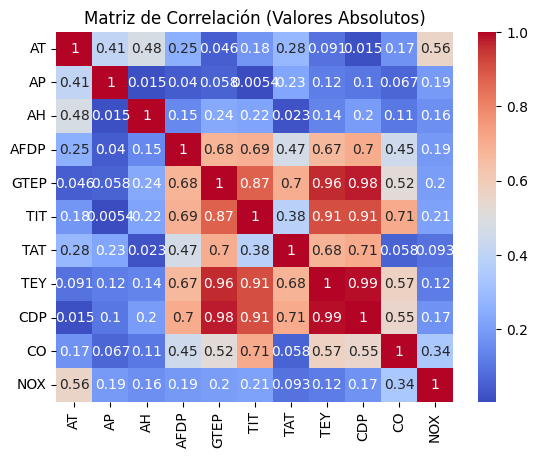

In [90]:
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación (Valores Absolutos)')
plt.show()

Como vemos, TEY está muy correlacionada con CDP y GTEP; y CDP está muy correlacionada con GTEP. Como podemos observar, las tres columnas están muy correlacionadas, por lo que al ser TEY nuestra columna objetivo, no podemos suprimir datos que están tan correlacionados con la solución, ya que supondría empeorar las predicciones

## 4. Preproceso

### 4.1 Normalización

Ahora normalizaremos los datos

In [91]:
for columna in datos:
  min = datos[columna].min()
  max = datos[columna].max()
  datos[columna] = (datos[columna] - min)/(max - min)


datos

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,0.249727,0.647291,0.782894,0.269481,0.272873,0.853147,0.980288,0.435959,0.385552,0.007397,0.596213
1,0.242929,0.639409,0.790252,0.268594,0.271657,0.852148,0.985848,0.435959,0.384421,0.010146,0.600734
2,0.233960,0.641379,0.798437,0.270749,0.273351,0.856144,0.989386,0.441369,0.412685,0.010227,0.615616
3,0.230247,0.639409,0.806004,0.270387,0.269919,0.856144,0.988880,0.440488,0.402887,0.005231,0.602096
4,0.230432,0.629557,0.802693,0.269898,0.270180,0.850150,0.984584,0.435959,0.387813,0.006056,0.597021
...,...,...,...,...,...,...,...,...,...,...,...
36728,0.227552,0.840394,0.908034,0.195303,0.060344,0.361638,0.772050,0.113991,0.105366,0.249251,0.673017
36729,0.240026,0.842365,0.919017,0.200047,0.057260,0.367632,0.789487,0.110342,0.092742,0.252675,0.669581
36730,0.270360,0.840394,0.934560,0.221864,0.050352,0.371628,0.819813,0.098012,0.114976,0.258797,0.747216
36731,0.279629,0.844335,0.921172,0.343225,0.254801,0.760240,0.987364,0.394942,0.361622,0.075121,0.413095


### 4.2 Aleatorización

Ahora aleatorizamos los datos para continuar con la práctica. Además, eliminamos la columna TEY, ya que es la columna que queremos predecir

In [92]:
datos = datos.sample(frac=1, random_state=random.seed(123))
X = datos.drop("TEY", axis = 1)
y = datos["TEY"]
X


,AT,AP,AH,AFDP,GTEP,TIT,TAT,CDP,CO,NOX
14263,0.332806,0.607882,0.916061,0.115513,0.264662,0.832168,0.986859,0.365956,0.046390,0.455923
16321,0.470347,0.625616,0.774749,0.181073,0.283257,0.851149,0.984332,0.380653,0.057958,0.542461
31759,0.628892,0.653202,0.427183,0.361240,0.687636,0.991009,0.757645,0.687406,0.070155,0.432360
2347,0.448472,0.466010,0.998949,0.265933,0.202972,0.735265,0.980541,0.282484,0.038549,0.443604
16316,0.488807,0.647291,0.829377,0.374928,0.644018,0.991009,0.486732,0.758441,0.022488,0.446104
...,...,...,...,...,...,...,...,...,...,...
7944,0.236041,0.653202,0.918912,0.705841,0.719915,0.991009,0.352034,0.838710,0.008513,0.379363
12044,0.631061,0.605911,0.784313,0.238050,0.100356,0.575425,0.981804,0.131934,0.092067,0.299303
13719,0.643498,0.434483,0.784720,0.276977,0.091233,0.557443,0.987364,0.121382,0.117116,0.311313
28595,0.307655,0.678818,0.775852,0.077835,0.162612,0.624376,0.983826,0.248756,0.057190,0.496686


## 5. Implementación del modelo lineal Adaline

In [110]:
class Adaline:
  """ Esta clase representa un modelo lineal Adaline"""
  def __init__(self, learning_rate=0.1, n_iter = 1000, random_seed = 28):
    self.learning_rate = learning_rate
    self.n_iter = n_iter
    self.random_seed = random_seed
    self.weights = None
    self.umbral = 0
    self.costes = []

  def fit(self, X, y):
    """ Método que entrena el modelo """
    # Inicializamos el modelo
    self.__initialize_Adaline(X)
    # Realizamos la modificación de los pesos n_iter veces
    for i in range(self.n_iter):
      # Obtenemos la salida
      salida = np.dot(X, self.weights) + self.umbral
      # Obtenemos los errrores
      errores = y - salida
      # Actualizamos el vector de pesos
      self.weights += self.learning_rate * X.T.dot(errores)
      # Actualizamos el umbral
      self.umbral += self.learning_rate * np.sum(errores)
      # Obtenemos y guardamos el coste para cada época
      coste = (errores**2).sum() / 2.0
      self.costes.append(coste)

  def predict(self,X_test):
    """ Método que realiza predicciones con el modelo entrenado """
    # Calcular la salida del Adaline para el conjunto de prueba
    salida = np.dot(X_test, self.weights) + self.umbral
    return salida


  def __initialize_Adaline(self, X):
    """ Método privado que inicializa los pesos y el umbral del Adaline de forma aleatoria """
    # Inicializamos la semilla de aleatoriedad
    np.random.seed(self.random_seed)
    # Generamos tantos números aleatorios desde -1 hasta 1 como atributos tenga el conjunto
    self.weights = np.random.uniform(-1, 1, size=(X.shape[1]))
    # Generamos el umbral de manera aleatoria
    self.umbral = np.random.uniform(-1, 1)

A continuación, comprobamos nuestra implementación del Adaline utilizando los datos artificiales proporcionados en aulaglobal. Para ello, utilizamos los hiperparámetros learning_rate (tasa de aprendizaje) = 0.001 y n_iter (número de iteraciones) = 1000.

In [111]:
# Leemos el conjunto de datos de aulaglobal
datos_prueba = pd.read_csv("datosArtificiales.txt", delimiter=' ', header=None)
# Dividimos los datos en atributos (X) y salida (y)
X_prueba = datos_prueba.iloc[:,:2]
y_prueba = datos_prueba.iloc[:,-1]
# Entrenamos el modelo
modelo_prueba = Adaline()
modelo_prueba.fit(X_prueba,y_prueba)
print(modelo_prueba.costes)

<ipython-input-110-fda0010c12d4>:24: RuntimeWarning: invalid value encountered in double_scalars
  self.umbral += self.learning_rate * np.sum(errores)


[2076.3280166311943, 42907815.67292914, 963402476335.085, 2.163554687803976e+16, 4.8587910006152895e+20, 1.091160309073791e+25, 2.450467245763827e+29, 5.503123301523359e+33, 1.2358608801697947e+38, 2.775427755200874e+42, 6.232901573258834e+46, 1.3997504330326458e+51, 3.1434818146031944e+55, 7.059456947144609e+59, 1.5853736502330985e+64, 3.560344130818784e+68, 7.995623194564881e+72, 1.795612668901243e+77, 4.032487247410998e+81, 9.055935994527482e+85, 2.0337318311330508e+90, 4.567242042637252e+94, 1.0256858626445237e+99, 2.303428368822268e+103, 5.172911554630702e+107, 1.1617037592409949e+112, 2.608889809891607e+116, 5.858899901127292e+120, 1.3157592137958317e+125, 2.95485899725907e+129, 6.63585829545079e+133, 1.4902442166665006e+138, 3.3467077300768173e+142, 7.515850425918783e+146, 1.6878679640031476e+151, 3.790520170656356e+155, 8.512539766484901e+159, 1.9116989229327645e+164, 4.293187312123876e+168, 9.641401726954724e+172, 2.165212475076915e+177, 4.8625139735874e+181, 1.091996393679230

Podemos observar que el error cuadrático medio desciende en cada época, y se va aproximando a 0, por lo que el modelo está correctamente implementado.

## División de datos

Vamos a dividir los datos en conjuntos train, test y validacion


In [95]:
# Dividir los datos originales en conjuntos de entrenamiento (70%) y prueba (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Dividir el conjunto de prueba en conjuntos de validación (15%) y prueba (15%)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)



Entrenamos el modelo

In [109]:
modelo = Adaline(learning_rate=0.00002, n_iter = 3000)
modelo.fit(X_train, y_train)
print(modelo.costes)

[11688.727221135092, 14436.38125315539, 17907.159873072153, 22284.86323396971, 27800.709603788862, 34745.48444959775, 43484.81240348846, 54478.353600033486, 68303.93172873263, 85687.85985112522, 107543.05516338376, 135016.942498331, 169551.65989283158, 212959.72493875498, 267519.1317474352, 336092.86774226587, 422279.12063202605, 530600.0560215204, 666739.069657638, 837838.9614499097, 1052876.6745669956, 1323134.2597760046, 1662790.7734988267, 2089666.1626605354, 2626156.163159186, 3300407.2600250407, 4147793.3518094514, 5212771.59019941, 6551214.758709074, 8233342.555203233, 10347405.563594362, 13004315.188758329, 16343462.457249679, 20540030.95845164, 25814187.588625073, 32442633.27642388, 40773119.681320444, 51242693.4616913, 64400625.270646214, 80937226.41487761, 101720064.99918893, 127839481.58224519, 160665792.25395453, 201921180.20788208, 253770047.4918935, 318932567.105702, 400827392.78529406, 503751013.52838284, 633103162.4262512, 795670105.5372437, 999980673.1264844, 12567537

Realizamos la predicción

In [108]:
modelo.predict(X_test)

array([0.55480402, 0.43780157, 0.12284741, ..., 0.42865007, 0.34149237,
       0.31352674])